<h3>Charlie AutoEncoder</h3>

In [87]:
# @title
# Generate random symbols as input
def generate_symbols(input_length, M):
    return torch.randint(0, M, (input_length,))  # generate (batch_size) random symbols between 0 and M - 1

# Create sliding windows from input data
def create_windows(data, window_size, step_size):
    num_windows = (len(data) - window_size) // step_size + 1
    windows = torch.stack([
        data[i:i + window_size]  # Extract rows for each window
        for i in range(0, num_windows * step_size, step_size)
    ])

    return windows

def plot_two_lines(x1, y1, x2, y2, title, x_label, y_label, label1="Line 1", label2="Line 2"):
    """
    Creates an interactive Plotly plot for two solid lines over the same x-axis.

    Parameters:
    - x1, y1: Data for the first line
    - x2, y2: Data for the second line
    - title: Plot title
    - x_label: Label for the x-axis
    - y_label: Label for the y-axis
    - label1: Legend name for the first line (default: "Line 1")
    - label2: Legend name for the second line (default: "Line 2")
    """

    # Create an interactive figure
    fig = go.Figure()

    # Add first line trace (solid blue)
    fig.add_trace(go.Scatter(
        x=x1, y=y1,
        mode='lines', name=label1,
        line=dict(color='blue', width=2)  # Solid line, blue color
    ))

    # Add second line trace (solid red)
    fig.add_trace(go.Scatter(
        x=x2, y=y2,
        mode='lines', name=label2,
        line=dict(color='red', width=2)  # Solid line, red color
    ))

    # Configure layout for better visibility
    fig.update_layout(
        title=title,
        xaxis_title=x_label,
        yaxis_title=y_label,
        template="plotly_white",
        hovermode="x",  # Enables hover tool on x-axis
    )

    # Show the interactive plot
    fig.show()

def plot_losses(losses):
    plt.figure(figsize=(8, 5))
    plt.plot(losses, label="Training Loss", color="blue", alpha=0.7)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

# REMEMBER TO IMPORT: model_weights_windowed.pth, best_params_windowed.json

# MODIFIED TRAINING (INTEGRATION)

In [117]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import json
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

def loader(weights_filepath, params_filepath):
    weights = torch.load(weights_filepath, weights_only=True, map_location=torch.device('cpu'))
    with open(params_filepath, "r") as f:
        params = json.load(f)
    return weights, params

# Load model weights and parameters
weights, params = loader(
    r"C:\Users\tomha\Documents\Capstone D2 - PC\Constellation\256QAM and 256 PSK\Basic\model_weights.pth",
    r"C:\Users\tomha\Documents\Capstone D2 - PC\Constellation\256QAM and 256 PSK\Basic\best_params.json"
)

# Hyperparameters
M = 256
n = 2
window_size = 512
epochs = 100
learning_rate = 1e-4

# Define Transmitter
class Transmitter(nn.Module):
    def __init__(self, M, n):
        super(Transmitter, self).__init__()
        self.fc1 = nn.Linear(M, 8 * M)
        self.fc2 = nn.Linear(8 * M, 8 * M) # try wider model deeper
        self.fc3 = nn.Linear(8 * M, n)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define Channel
# Define the wider model
class FiberOpticFNN0(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout):
        super(FiberOpticFNN0, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),  # Batch normalization
            nn.ReLU(),
            nn.Dropout(dropout),  # Dropout for regularization
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),  # Batch normalization
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

class IdentityChannel(nn.Module):
    def forward(self, x):
        return x

# Define Receiver
class Receiver(nn.Module):
    def __init__(self, n, M):
        super(Receiver, self).__init__()
        self.fc1 = nn.Linear(n, 8 * M)
        self.fc2 = nn.Linear(8 * M, 8 * M)  # try wider model -> deeper
        self.fc3 = nn.Linear(8 * M, M)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=-1)

transmitter = Transmitter(M, n)

channel = FiberOpticFNN0(2 * window_size, params["hidden_dim"], n, params["dropout"])
channel.load_state_dict(weights["model weights"], strict=False)
# channel = IdentityChannel();

receiver = Receiver(n, M)

for param in transmitter.parameters():
    assert param.requires_grad
for param in channel.parameters():
    param.requires_grad = False
for param in receiver.parameters():
    assert param.requires_grad

# Optimizer and Loss Function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(transmitter.parameters()) + list(receiver.parameters()), lr=learning_rate)

# Training loop with batching
transmitter.train()
channel.eval()
receiver.train()
training_losses = []

for epoch in range(epochs):
  symbols = torch.randint(0, M, (window_size,))
  target_symbol = symbols[window_size // 2]
  symbols_one_hot = F.one_hot(symbols, num_classes=M).float()

  transmitted = transmitter(symbols_one_hot)

  transmitted_flat = transmitted.view(1, -1)
  received = channel(transmitted_flat)

  decoded = receiver(received)

  optimizer.zero_grad()
  loss = criterion(decoded, target_symbol.unsqueeze(0))
  loss.backward()
  optimizer.step()

  print(f"Epoch [{epoch+1}/{epochs}] - Loss: {loss.item():.4f}")
  training_losses.append(loss.item())

Epoch [1/100] - Loss: 5.4809
Epoch [2/100] - Loss: 5.5839
Epoch [3/100] - Loss: 5.5433
Epoch [4/100] - Loss: 5.5124
Epoch [5/100] - Loss: 5.4989
Epoch [6/100] - Loss: 5.5554
Epoch [7/100] - Loss: 5.5063
Epoch [8/100] - Loss: 5.6948
Epoch [9/100] - Loss: 5.5529
Epoch [10/100] - Loss: 5.5263
Epoch [11/100] - Loss: 5.6062
Epoch [12/100] - Loss: 4.8407
Epoch [13/100] - Loss: 5.5210
Epoch [14/100] - Loss: 5.5216
Epoch [15/100] - Loss: 5.6231
Epoch [16/100] - Loss: 5.6962
Epoch [17/100] - Loss: 5.6439
Epoch [18/100] - Loss: 5.6668
Epoch [19/100] - Loss: 5.4898
Epoch [20/100] - Loss: 5.4459
Epoch [21/100] - Loss: 5.5525
Epoch [22/100] - Loss: 5.6656
Epoch [23/100] - Loss: 5.6467
Epoch [24/100] - Loss: 5.5672
Epoch [25/100] - Loss: 5.6849
Epoch [26/100] - Loss: 5.7101
Epoch [27/100] - Loss: 5.6005
Epoch [28/100] - Loss: 5.4906
Epoch [29/100] - Loss: 5.8069
Epoch [30/100] - Loss: 5.5083
Epoch [31/100] - Loss: 5.5452
Epoch [32/100] - Loss: 5.6660
Epoch [33/100] - Loss: 5.5602
Epoch [34/100] - Lo

<h3>AutoEncoder Attempt #1.5 - no sliding window</h3>

In [135]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim

class TransmitterRecieverModel(nn.Module):
    def __init__(self, input_size,hidden_size,channel_size,channel_func,weight_init=1):
        super().__init__()
        self.transmitter_fc1 = nn.Linear(input_size, hidden_size)
        self.transmitter_fc2 = nn.Linear(hidden_size, channel_size)

        self.reciever_fc1 = nn.Linear(channel_size, hidden_size)
        self.reciever_fc2 = nn.Linear(hidden_size, input_size)

        self.channel_function = channel_func

        init.uniform_(self.transmitter_fc1.weight,a=-weight_init,b=weight_init)
        init.uniform_(self.transmitter_fc2.weight, a=-weight_init,b=weight_init)
        init.uniform_(self.reciever_fc1.weight, a=-weight_init,b=weight_init)
        init.uniform_(self.reciever_fc2.weight,a=-weight_init,b=weight_init)

    def forward(self, x):
        transmitter_output = F.sigmoid(self.transmitter_fc1(x))
        transmitter_output = self.transmitter_fc2(transmitter_output)

        channel_output = self.channel_function(transmitter_output)

        reciever_output = F.sigmoid(self.reciever_fc1(channel_output))
        reciever_output = self.reciever_fc2(reciever_output)

        return reciever_output
    
    def evaluate(self, x):
        with torch.no_grad():
            output = F.softmax(self.forward(x),dim=-1)
            output = [torch.argmax(o).item() for o in output]
            return output


    def train_model(self,x,y,epochs=10,learning_rate=0.001):
        training_loss = []
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(),lr=learning_rate)
        for epoch in range(epochs):
            optimizer.zero_grad()
            y_pred = self.forward(x)
            loss = criterion(y_pred,y)
            loss.backward()
            optimizer.step()
            training_loss.append(loss.item())
            #print(f"Epoch {epoch} Loss: {loss.item()}")
        return training_loss

C:\Users\tomha\AppData\Local\Temp\ipykernel_16608\841660291.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model.evaluate(torch.tensor(input_data_one_hot,dtype=torch.float32))


Input Data: 
tensor([220, 152,  30,  90,  89,  56, 104, 184, 252,  28,  59,  70, 180, 153,
        115, 179, 231, 178, 251, 144, 103,  74,  34,  81, 115,  20, 144, 205,
         22, 208,  67, 111,  46, 167,  39, 150, 165, 239,  75, 112,  22, 246,
        162,  35, 196, 130, 205, 158,  70, 220, 216,  77,  91, 198,  39, 250,
        133,  91, 130, 248,  72,  70, 217,  38, 247, 163, 137, 223,  66, 205,
        246, 238, 109,  94, 134,  51, 144,   2, 213, 194,  39,  52,  83,  99,
         29, 111,  94, 129,   9, 120,  41, 109, 123, 110,  44,  27, 172, 152,
        231, 159,  50, 133, 168,  61, 252, 167, 251,  41, 129,  75, 200, 248,
        113,  35,  75,  37, 246, 101,  69, 151, 226, 122, 178,  83, 183,   8,
        138,  50,  34, 133,  40, 194, 191, 190,  42,  82,  14, 113,  43,   5,
        235,  24, 239, 242, 248, 108,  79, 231, 234, 101, 246,  48,  35, 120,
         78, 125, 164,  48, 222, 190, 104, 154, 173,  10,  22, 168,  60,  62,
        216, 118, 164,  72, 168, 190,   1, 237, 188

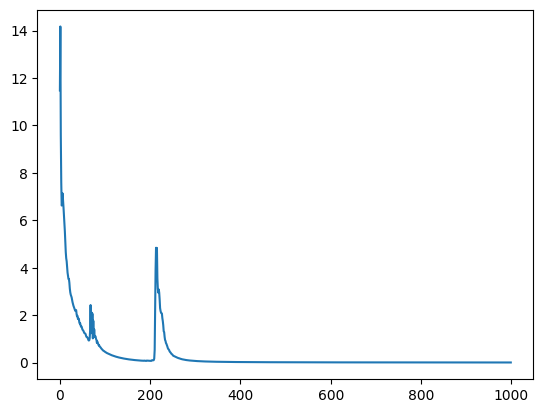

In [137]:
# identity matrix --> transmitter --> identity channel --> reciever --> identity matrix
import numpy as np
import torch
import matplotlib.pyplot as plt

input_size = 256
hidden_size = 128
channel_size = 2
channel_func = lambda x: x

model = TransmitterRecieverModel(input_size,hidden_size,channel_size,channel_func)

input_data = torch.randint(0, input_size, (input_size,), dtype=torch.long)

input_data_one_hot = torch.tensor(np.eye(input_size)[input_data],dtype=torch.float32)

training_loss = model.train_model(input_data_one_hot,input_data, learning_rate=0.1,epochs=1000)

output = model.evaluate(torch.tensor(input_data_one_hot,dtype=torch.float32))
print("Input Data: ")
print(input_data)
print("Output Data: ")
print(output)

plt.figure()
plt.plot(training_loss)
plt.show()

<h3>AutoEncoder Attempt #2 - With sliding window & Fiber Channel</h3>

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import json
from torch.utils.data import TensorDataset, DataLoader

# -----------------------------------------------------------------------------
def loader(weights_filepath, params_filepath):
    weights = torch.load(weights_filepath, weights_only=True, map_location=torch.device('cpu'))
    with open(params_filepath, "r") as f:
        params = json.load(f)
    return weights, params

# Load model weights and parameters
weights, params = loader(
    r"C:\Users\tomha\Documents\Capstone D2 - PC\Constellation\QPSK\Wider\model_weights.pth",
    r"C:\Users\tomha\Documents\Capstone D2 - PC\Constellation\QPSK\Wider\best_params.json"
)


In [128]:
class AutoEncoderV2(nn.Module):
    def __init__(self, alphabet_size, hidden_size, channel_size, channel_func, window_length):
        """
        Args:
            alphabet_size (int): Dimensionality of one-hot vectors (alphabet size).
            hidden_size (int): Hidden layer dimension.
            channel_size (int): Dimension of the transmitter output (e.g., 2 for I/Q).
            channel_func (callable): The fiber channel function. It expects an input of size (2 * window_length).
            window_length (int): Number of symbols per window.
        """
        super().__init__()
        self.alphabet_size = alphabet_size      # e.g., 4
        self.window_length = window_length        # e.g., 512
        self.channel_size = channel_size          # e.g., 2 (I/Q)

        # Transmitter: processes one symbol at a time.
        self.transmitter_fc1 = nn.Linear(alphabet_size, hidden_size)
        self.transmitter_fc2 = nn.Linear(hidden_size, channel_size)

        self.channel_function = channel_func

        # Receiver: decodes the channel output back to logits over the alphabet.
        self.reciever_fc1 = nn.Linear(channel_size, hidden_size)
        self.reciever_fc2 = nn.Linear(hidden_size, alphabet_size)

    def forward(self, x):
        """
        Args:
            x: Tensor of shape (total_length, alphabet_size), where total_length is divisible by window_length.
        Returns:
            A tensor of shape (num_windows, alphabet_size), where each row corresponds to the receiver's output for that window.
        """
        # Group input into non-overlapping windows.
        num_windows = x.shape[0] // self.window_length
        # x_windows shape: (num_windows, window_length, alphabet_size)
        x_windows = x.view(num_windows, self.window_length, self.alphabet_size)
        
        # Process each window individually through the transmitter,
        # and store the flattened outputs.
        flattened_windows = []
        for i in range(num_windows):
            # Get the i-th window. Shape: (window_length, alphabet_size)
            window = x_windows[i]
            
            # Process each symbol in the window through the transmitter.
            # tx_hidden shape: (window_length, hidden_size)
            tx_hidden = torch.sigmoid(self.transmitter_fc1(window))
            # Map each symbol to an I/Q pair. Shape: (window_length, channel_size)
            tx_symbols = self.transmitter_fc2(tx_hidden)
            
            # Flatten the window to a vector. Shape: (1, window_length * channel_size)
            window_flat = tx_symbols.view(1, -1)
            flattened_windows.append(window_flat)
        
        # Concatenate the flattened windows to form a batch.
        # Shape: (num_windows, window_length * channel_size)
        batch_flat = torch.cat(flattened_windows, dim=0)
        
        # Pass the entire batch of flattened windows through the fiber channel.
        # channel_out shape: (num_windows, channel_size)
        channel_out = self.channel_function(batch_flat)
        
        # Now, process each window individually through the receiver.
        window_outputs = []
        for i in range(num_windows):
            # Get the i-th channel output (a single window's output).
            ch_out = channel_out[i].unsqueeze(0)  # Shape: (1, channel_size)
            # Decode using the receiver.
            rx_hidden = torch.sigmoid(self.reciever_fc1(ch_out))
            rx_output = self.reciever_fc2(rx_hidden)  # Shape: (1, alphabet_size)
            window_outputs.append(rx_output)
        
        # Concatenate the decoded outputs from all windows.
        # Final shape: (num_windows, alphabet_size)
        outputs = torch.cat(window_outputs, dim=0)
        return outputs


    def evaluate(self, x):
        with torch.no_grad():
            output = self.forward(x)
            output_soft = F.softmax(output, dim=-1)
            preds = torch.argmax(output_soft, dim=-1)
            return preds

    def get_tx_symbols(self, x):
        """
        Returns the transmitter (I/Q) output for each symbol, before the channel.
        x: shape (total_length, alphabet_size).
        Returns: shape (num_windows*window_length, channel_size).
        """
        self.eval()
        with torch.no_grad():
            num_windows = x.shape[0] // self.window_length
            x_windows = x.view(num_windows, self.window_length, self.alphabet_size)
            
            tx_symbols_list = []
            for i in range(num_windows):
                window = x_windows[i]   # (window_length, alphabet_size)
                tx_hidden = torch.sigmoid(self.transmitter_fc1(window))
                tx_syms = self.transmitter_fc2(tx_hidden)    # (window_length, channel_size)
                tx_symbols_list.append(tx_syms)
            
            # Concatenate all windows
            tx_symbols_all = torch.cat(tx_symbols_list, dim=0)  # (num_windows*window_length, channel_size)
        return tx_symbols_all
    
    def get_channel_output(self, x):
        """
        Passes data through the transmitter and channel, returning the 
        channel's final I/Q for each window (one point per window).
        
        x: shape (total_length, alphabet_size).
        Returns: shape (num_windows, channel_size).
        """
        self.eval()
        with torch.no_grad():
            num_windows = x.shape[0] // self.window_length
            x_windows = x.view(num_windows, self.window_length, self.alphabet_size)
            
            flattened_windows = []
            for i in range(num_windows):
                window = x_windows[i]   # (window_length, alphabet_size)
                tx_hidden = torch.sigmoid(self.transmitter_fc1(window))
                tx_syms   = self.transmitter_fc2(tx_hidden)  # (window_length, channel_size)
                window_flat = tx_syms.view(1, -1)            # (1, window_length*channel_size)
                flattened_windows.append(window_flat)
    
            batch_flat = torch.cat(flattened_windows, dim=0)   # (num_windows, window_length*channel_size)
            channel_out = self.channel_function(batch_flat)    # (num_windows, channel_size)
        return channel_out



    def train_model(self, x, y, epochs=10, learning_rate=0.001):
        """
        Args:
            x: Tensor of shape (total_length, alphabet_size)
            y: Tensor of shape (num_windows,) with the target symbol (class index) for each window.
        """
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        loss_history = []

        for epoch in range(epochs):
            optimizer.zero_grad()
            y_pred = self.forward(x)  # Shape: (num_windows, alphabet_size)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()

            loss_history.append(loss.item())
            if epoch % 100 == 0:
                print(f"Epoch {epoch} Loss: {loss.item():.4f}")

        # Plot the loss over epochs.
        import matplotlib.pyplot as plt
        plt.figure(figsize=(8, 5))
        plt.plot(loss_history, label="Training Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Loss over Epochs")
        plt.legend()
        plt.show()
        return loss_history


In [129]:
# Define the wider model
class FiberOpticFNN2(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout):
        super(FiberOpticFNN2, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim * 2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, output_dim)
        )
    def forward(self, x):
        return self.fc(x)

# Set up the fiber channel.
channel = FiberOpticFNN2(window_length, params["hidden_dim"], 2, params["dropout"])
channel.load_state_dict(weights["model weights"], strict=False)
channel_func = lambda x: channel.forward(x)


Epoch 0 Loss: 1.4914
Epoch 100 Loss: 0.0676
Epoch 200 Loss: 0.0240
Epoch 300 Loss: 0.0219
Epoch 400 Loss: 0.0603
Epoch 500 Loss: 0.0524
Epoch 600 Loss: 0.0407
Epoch 700 Loss: 0.0158
Epoch 800 Loss: 0.0061
Epoch 900 Loss: 0.0585


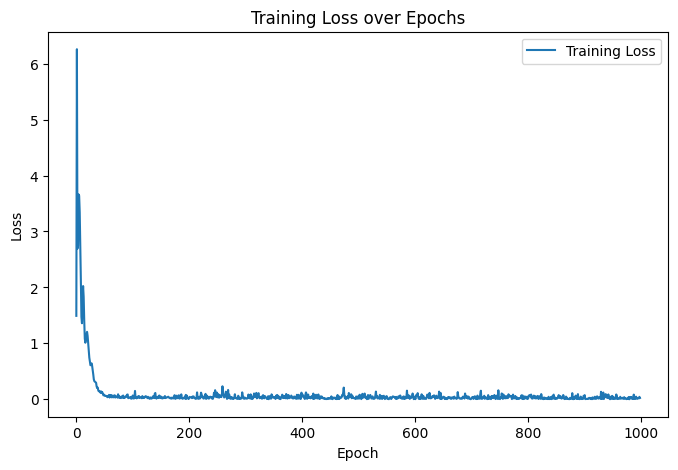

In [130]:
# Testing the autoencoder

#1 - Initialize the AutoEncoder

alphabet_size = 4   # One-hot vector dimension; using 4096 symbols.
hidden_size = 100
channel_size = 2        # I/Q components.
window_size = 512       # Each window has 1024 symbols.
total_length = 40960    


# Instantiate the autoencoder model.
model = AutoEncoderV2(
    alphabet_size=alphabet_size, 
    hidden_size=hidden_size, 
    channel_size=channel_size, 
    channel_func=channel_func, 
    window_length=window_size 
)


num_windows = total_length // window_size

# Generate one random symbol per window.
random_symbols = np.random.randint(0, alphabet_size, size=num_windows)  # shape: (80,)
# One-hot each symbol: shape (80, alphabet_size)
random_symbols_onehot = np.eye(alphabet_size)[random_symbols]
# Replicate each row 512 times => shape (80*512, alphabet_size) = (40960, 4)
repeated_symbols = np.repeat(random_symbols_onehot, repeats=window_size, axis=0)
# Build PyTorch tensor
input_tensor = torch.tensor(repeated_symbols, dtype=torch.float32)

# Target is just that single symbol for each window
target_tensor = torch.tensor(random_symbols, dtype=torch.long)

# --------------------------------------------------------------------------
# 5. Train the model
# --------------------------------------------------------------------------
loss_history = model.train_model(input_tensor, target_tensor, learning_rate=0.1, epochs=1000)


In [131]:
# Evaluate the model.
print("Evaluating the model...")
output = model.evaluate(input_tensor)

# Convert tensors to NumPy arrays.
y_true = target_tensor.cpu().numpy()
y_pred = output.cpu().numpy()

print("Target Symbols (middle of each window):")
print(y_true)
print("Output Predictions:")
print(y_pred)

# Calculate prediction accuracy.
correct = np.sum(y_true == y_pred)
total = y_true.shape[0]
accuracy = correct / total
print(f"Accuracy: {accuracy:.3f} ({correct}/{total})")


Evaluating the model...
Target Symbols (middle of each window):
[3 0 0 1 2 1 3 0 3 3 1 3 0 1 1 3 2 3 2 3 3 2 3 1 0 2 1 0 0 1 1 3 0 2 1 1 1
 2 1 0 1 3 0 2 2 1 3 2 3 3 1 1 2 3 1 2 3 1 0 1 0 0 1 3 1 1 3 0 0 1 0 0 1 1
 0 2 3 1 0 3]
Output Predictions:
[3 0 0 1 2 1 3 0 3 3 1 3 0 1 1 3 2 3 2 3 3 2 3 1 0 2 1 0 0 1 1 3 0 2 1 1 1
 2 1 0 1 3 0 2 2 1 3 2 3 3 1 1 2 3 1 2 3 1 0 1 0 0 1 3 1 1 3 0 0 1 0 0 1 1
 0 2 3 1 0 3]
Accuracy: 1.000 (80/80)


In [140]:
import numpy as np
import torch

# Let's assume your model is already defined and trained as `model`.
# We'll create a function that generates new test data:
def generate_test_data(num_windows, alphabet_size=4, window_size=512):
    """
    Generates new test data where each "logical" window is a single symbol
    repeated 512 times so that the channel sees the correct dimension.

    Returns:
        test_input_tensor: Tensor of shape (num_windows * window_size, alphabet_size)
        test_target_tensor: Tensor of shape (num_windows,)
    """
    # Generate random symbols (one per window).
    random_test_symbols = np.random.randint(0, alphabet_size, size=num_windows)
    # One-hot each symbol: shape (num_windows, alphabet_size)
    random_test_onehot = np.eye(alphabet_size)[random_test_symbols]
    # Replicate each row 512 times => shape (num_windows*512, alphabet_size)
    repeated_test_data = np.repeat(random_test_onehot, repeats=window_size, axis=0)
    
    # Build PyTorch tensor
    test_input_tensor = torch.tensor(repeated_test_data, dtype=torch.float32)
    test_target_tensor = torch.tensor(random_test_symbols, dtype=torch.long)
    return test_input_tensor, test_target_tensor

# Example usage:
num_test_windows = 50  # E.g., produce 20 new test windows.

# Generate the new test data
new_test_input, new_test_target = generate_test_data(num_test_windows, 
                                                     alphabet_size=alphabet_size, 
                                                     window_size=window_size)

# Evaluate the model on this new data
print("Evaluating on new test data...")
output_test = model.evaluate(new_test_input)
y_true_test = new_test_target.cpu().numpy()
y_pred_test = output_test.cpu().numpy()

print("New Test Target Symbols:")
print(y_true_test)
print("New Test Predictions:")
print(y_pred_test)

# Compute accuracy
correct_new = np.sum(y_true_test == y_pred_test)
total_new = y_true_test.shape[0]
accuracy_new = correct_new / total_new
print(f"New Test Accuracy: {accuracy_new:.3f} ({correct_new}/{total_new})")


Evaluating on new test data...
New Test Target Symbols:
[0 2 3 3 2 3 2 2 3 3 3 2 2 3 2 1 1 3 2 2 2 3 2 0 2 1 0 3 1 2 2 3 0 0 2 0 3
 1 2 3 1 1 1 1 2 2 2 3 0 0]
New Test Predictions:
[0 1 0 3 2 0 2 2 3 0 0 2 2 3 1 1 1 0 2 2 2 3 2 0 1 1 0 3 1 2 2 0 0 0 2 0 0
 1 2 3 1 1 1 1 1 2 2 3 0 0]
New Test Accuracy: 0.780 (39/50)


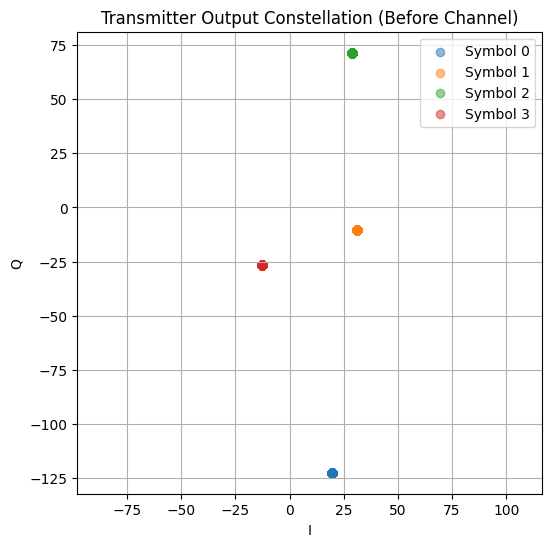

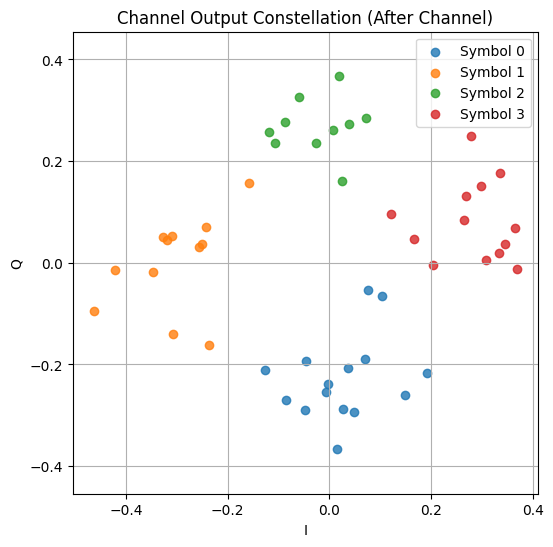

In [137]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Suppose 'model' is already instantiated and trained, and 'generate_test_data' is defined.
num_test_windows = 50
new_test_input, new_test_target = generate_test_data(num_test_windows,
                                                     alphabet_size=4,
                                                     window_size=512)

# 1) Get the transmitter output for each symbol (before channel).
tx_syms_all = model.get_tx_symbols(new_test_input)  # shape (num_windows*512, 2)
tx_syms_np   = tx_syms_all.cpu().numpy()

# 2) Get the channel output (one I/Q pair per window).
ch_out_all = model.get_channel_output(new_test_input)  # shape (num_windows, 2)
ch_out_np  = ch_out_all.cpu().numpy()

# Because each logical window is just one unique symbol repeated,
# we replicate the symbol IDs 512 times for the transmitter plot,
# and use them once for the channel-out plot.
symbol_ids_repeated = np.repeat(new_test_target.cpu().numpy(), 512)
symbol_ids_single   = new_test_target.cpu().numpy()  # one per window

# Let's define some colors (up to 8 symbols).
colors = ["red", "blue", "green", "orange", "purple", "brown", "cyan", "magenta"]

# 3a) Plot the transmitter (before channel) constellation:
plt.figure(figsize=(6, 6))
for sym_id in range(model.alphabet_size):
    idx = (symbol_ids_repeated == sym_id)
    plt.scatter(
        tx_syms_np[idx, 0],
        tx_syms_np[idx, 1],
        label=f"Symbol {sym_id}",
        alpha=0.5
    )
plt.title("Transmitter Output Constellation (Before Channel)")
plt.xlabel("I")
plt.ylabel("Q")
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()

# 3b) Plot the channel output constellation (one point per window):
plt.figure(figsize=(6, 6))
for sym_id in range(model.alphabet_size):
    idx = (symbol_ids_single == sym_id)
    plt.scatter(
        ch_out_np[idx, 0],
        ch_out_np[idx, 1],
        label=f"Symbol {sym_id}",
        alpha=0.8
    )
plt.title("Channel Output Constellation (After Channel)")
plt.xlabel("I")
plt.ylabel("Q")
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()

# Optionally compute final predictions and accuracy as well, similar to your code above.


<h3> AutoEncoder Attempt #3 - Fixing constellation clump </h3>

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import plotly.graph_objects as go
import json
import os

def loader(weights_filepath, params_filepath):
    weights = torch.load(weights_filepath, weights_only=True, map_location=torch.device('cpu'))
    with open(params_filepath, "r") as f:
        params = json.load(f)
    return weights, params

def generate_data(alphabet_size, total_size):
    input = np.random.randint(0, alphabet_size-1, total_size)
    input_one_hot = np.eye(alphabet_size)[input]
    input_windows = input.reshape(-1, window_size)
    target_data = input_windows[:, window_size // 2]

    # Convert data to PyTorch tensors.
    input_tensor = torch.tensor(input_one_hot, dtype=torch.float32)
    target_tensor = torch.tensor(target_data, dtype=torch.long)

    return input_tensor, target_tensor

#--------------------------------------------------------------------------------------------------
# Define the basic FNN model
class FiberOpticFNN0(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout):
        super(FiberOpticFNN0, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),  # Batch normalization
            nn.ReLU(),
            nn.Dropout(dropout),  # Dropout for regularization
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),  # Batch normalization
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

# Define the deeper model
class FiberOpticFNN1(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout):
        super(FiberOpticFNN1, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

# Define the wider model
class FiberOpticFNN2(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout):
        super(FiberOpticFNN2, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim * 2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, output_dim)
        )
    def forward(self, x):
        return self.fc(x)

# Define the dynamic model
class FiberOpticFNN3(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout):
        super(FiberOpticFNN3, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, int(hidden_dim * 0.75)),
            nn.BatchNorm1d(int(hidden_dim * 0.75)),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(int(hidden_dim * 0.75), int(hidden_dim * 0.5)),
            nn.BatchNorm1d(int(hidden_dim * 0.5)),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(int(hidden_dim * 0.5), output_dim)
        )
    def forward(self, x):
        return self.fc(x)

# Define the noise-resilient model
class FiberOpticFNN4(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout):
        super(FiberOpticFNN4, self).__init__()

        # Initial feature extraction
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU()
        )

        # Noise-focused branch (captures small deviations)
        self.noise_branch = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.Tanh(),
            nn.Dropout(dropout)
        )

        # Residual connection for refined outputs
        self.residual = nn.Linear(hidden_dim, hidden_dim)

        # Final layer combining noise and refined features
        self.combined = nn.Sequential(
            nn.Linear(hidden_dim + hidden_dim // 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        # Extract features
        features = self.feature_extractor(x)

        # Process noise-sensitive features
        noise_features = self.noise_branch(features)

        # Add residual connection
        refined_features = features + self.residual(features)

        # Combine noise-sensitive and refined features
        combined_input = torch.cat((refined_features, noise_features), dim=1)

        # Final output
        output = self.combined(combined_input)
        return output


In [3]:

class AutoEncoderV3(nn.Module):
    def __init__(self, input_size, hidden_size, channel_size, channel_func, window_length, scaling_factor):
        """
        Args:
            input_size (int): Dimensionality of one-hot vectors (alphabet size).
            hidden_size (int): Hidden layer dimension.
            channel_size (int): Dimension of the transmitter output (e.g., 2 for I/Q).
            channel_func (callable): The fiber channel function. It expects an input of size (2 * window_length).
            window_length (int): Number of symbols per window.
        """
        super().__init__()
        self.input_size = input_size      # e.g., 4096 (alphabet size)
        self.window_length = window_length  # e.g., 1024
        self.channel_size = channel_size    # e.g., 2 (I/Q)
        self.scaling_factor = scaling_factor

        # Transmitter: processes one symbol at a time.
        self.transmitter_fc1 = nn.Linear(input_size, hidden_size)
        self.transmitter_fc2 = nn.Linear(hidden_size, channel_size)

        # Receiver: decodes the channel output back to logits over the alphabet.
        self.receiver_fc1 = nn.Linear(channel_size, hidden_size)
        self.receiver_fc2 = nn.Linear(hidden_size, input_size)

        self.channel_function = channel_func

    def forward(self, x):
        """
        First passes each symbol (one-hot encoded vectors) through the transmitter.
        Then arranges the transmitter outputs into windows, and passes each window through the channel.
        Then passes the channel output through the receiver.
        Args:
            x: Tensor of shape (total_length, input_size), where total_length is divisible by window_length.
        Returns:
            A tensor of shape (num_windows, input_size), where each row corresponds to the receiver's
            output for that window.
        """
        # Group input into non-overlapping windows of size window_length.
        num_windows = x.shape[0] // self.window_length #total_length / window_length
        # New shape: (num_windows, window_length, input_size)
        x_windows = x.view(num_windows, self.window_length, self.input_size)

        # flatten input to get an array of all the one hot encoded vectors
        x_flat = x_windows.view(-1, self.input_size)  # Shape: (num_windows * window_length, input_size)
        tx_hidden = torch.sigmoid(self.transmitter_fc1(x_flat)) # passing each symbols one at a time (first layer)
        # mapping each symbol to an (I,Q) pair (second layer)
        tx_symbols = self.transmitter_fc2(tx_hidden)     # Shape: (num_windows * window_length, channel_size)

        # Reshape back into windows: (num_windows, window_length, channel_size)
        tx_windows = tx_symbols.view(num_windows, self.window_length, self.channel_size)

        # Flatten each window to create a vector of size (window_length * channel_size).
        # With window_length=1024 and channel_size=2, this gives a vector of size 2048.
        tx_windows_flat = tx_windows.view(num_windows, -1) # [I1, Q1, I2, Q2, ...]

        # Pass each flattened window through the fiber channel.
        channel_out = self.channel_function(tx_windows_flat)  # Expected shape: (num_windows, channel_size)

        # Decode the channel output using the receiver.
        rx_hidden = torch.sigmoid(self.receiver_fc1(channel_out))
        rx_output = self.receiver_fc2(rx_hidden)  # Shape: (num_windows, input_size)
        return rx_output

    def train_model(self, x_train, y_train, x_val, y_val, x_test, y_test, learning_rate, patience, epochs=10):
        """
        Args:
            x_train: Tensor of shape (total_length, input_size)
            y_train: Tensor of shape (num_windows,) with the target symbol (class index) for each window.
            x_val:
            y_val:
            x_test:
            y_test:
            learning_rate:
            patience:
            epochs:
        """
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        train_loss = []
        val_loss = []
        best_val_loss = float('inf')
        counter = 0

        for epoch in range(epochs):
            # Training phase
            self.train()
            optimizer.zero_grad()
            y_pred = self.forward(x_train)  # Shape: (num_windows, input_size)
            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()

            current_train_loss = loss.item()
            train_loss.append(current_train_loss)

            # Validation phase
            self.eval()
            with torch.no_grad():
                y_pred_val = self.forward(x_val)
                current_val_loss = criterion(y_pred_val, y_val).item()
                val_loss.append(current_val_loss)

                if current_val_loss < best_val_loss:
                    best_val_loss = current_val_loss
                    best_weights = {k: v.clone().detach() for k, v in self.state_dict().items()}

                    counter = 0
                else:
                    counter += 1

            if epoch % 25 == 0:
                print(f"Epoch {epoch} - Train Loss: {current_train_loss:.4f}, Val Loss: {current_val_loss:.4f}")

            if counter >= patience:
                print(f"Early stopping at epoch {epoch}. Best Val Loss: {best_val_loss:.4f}")
                break

        # Testing phase
        self.load_state_dict(best_weights)
        y_test_pred = torch.argmax(self.forward(x_test), dim=1)

        return train_loss, val_loss, y_test, y_test_pred, best_weights


In [10]:
alphabet_size = 4   # One-hot vector dimension; using 4096 symbols.
hidden_size = 100
channel_size = 2        # I/Q components.
window_size = 512       # Each window has 1024 symbols.
total_length = 40960    


weights, params = loader(
    r"C:\Users\tomha\Documents\Capstone D2 - PC\Constellation\QPSK\Wider\model_weights.pth",
    r"C:\Users\tomha\Documents\Capstone D2 - PC\Constellation\QPSK\Wider\best_params.json"
)


# -----------------------------------------------------------------------------
# Set up the fiber channel.
# The channel expects a flattened input of size 2 * window_length = 2 * 1024 = 2048.
channel = FiberOpticFNN2(2 * window_size, params["hidden_dim"], channel_size, params["dropout"])
channel.load_state_dict(weights["model weights"], strict=False)
#channel_func = lambda x: channel.forward(x)
def identity_channel(x):
    # Input is [num_windows, window_length * channel_size]
    # Return [num_windows, channel_size] by averaging across the window
    return x.view(x.shape[0], -1, 2).mean(dim=1)


channel_func = lambda x: channel.forward(x)

# Instantiate the autoencoder model.
model = AutoEncoderV3(
    input_size=alphabet_size,
    hidden_size=hidden_size,
    channel_size=channel_size,
    channel_func=channel_func,
    window_length=window_size,
    scaling_factor=params["scaling_factor"]
)

# -----------------------------------------------------------------------------
train_input, train_target = generate_data(alphabet_size, total_length)
val_input, val_target = generate_data(alphabet_size, total_length//4)
test_input, test_target = generate_data(alphabet_size, total_length//4)

# -----------------------------------------------------------------------------
# Step 1: Generate some symbols
num_symbols = 100
input_indices = torch.randint(0, alphabet_size, (num_symbols,))
input_onehot = torch.eye(alphabet_size)[input_indices]  # Shape: (num_symbols, alphabet_size)

# Step 2: Pass through transmitter manually
model.eval()
with torch.no_grad():
    tx_hidden = torch.sigmoid(model.transmitter_fc1(input_onehot))
    tx_symbols = model.transmitter_fc2(tx_hidden)  # Shape: (num_symbols, channel_size)

# Step 3: Group into a fake window and pass through the channel
tx_window = tx_symbols.view(1, -1)  # Shape: (1, num_symbols * channel_size)
channel_out = model.channel_function(tx_window) / model.scaling_factor  # Shape: (1, channel_size)

# Step 4 (Optional): Visualize

plt.figure(figsize=(6, 6))
plt.scatter(tx_symbols[:, 0].numpy(), tx_symbols[:, 1].numpy(), label="Transmitter Output")
plt.title("I/Q Constellation Before Channel")
plt.xlabel("I")
plt.ylabel("Q")
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.show()

# Train the model and plot loss.
train_loss, val_loss, y_test, y_test_pred, best_weights = model.train_model(
    train_input,
    train_target,
    val_input,
    val_target,
    test_input,
    test_target,
    learning_rate=0.01,
    patience=75,
    epochs=1000)

# Calculate SER
num_errors = (y_test_pred != y_test).sum().item()
ser = num_errors / y_test.size(0)
print(f"Symbol Error Rate (SER): {ser:.4f}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x200 and 1024x1152)

In [6]:
print(y_test)
print(y_test_pred)

tensor([2, 1, 1, 1, 0, 1, 1, 1, 2, 2, 0, 0, 2, 2, 0, 1, 2, 2, 1, 0])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
